# Importamos las librerias

In [1]:
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import signal

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, GridSearchCV  , StratifiedGroupKFold, cross_validate
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor, MLPClassifier


import matplotlib.pyplot as plt 
import seaborn as sns

# Cargamos los datos

In [2]:
dataset_path_root = "/home/bruno/Academico/Doctorado/Neuro_Fairness/Shu_Dataset/001_Dataset_CSP_per_subject/"
participants=["sub-001","sub-002","sub-003","sub-004","sub-005",
              "sub-006","sub-007","sub-008","sub-009","sub-010",
              "sub-011","sub-012","sub-013","sub-014","sub-015",
              "sub-016","sub-017","sub-018","sub-019","sub-020",
              "sub-021","sub-022","sub-023","sub-024","sub-025"]
sessions = ["ses-01","ses-02","ses-03","ses-04","ses-05"]

In [3]:
dataset={}
for participant in participants:
    dataset[participant]={}
    data_path=participant+"_task_motorimagery_eeg_preprocessing_csp.mat"
    data=sio.loadmat(dataset_path_root + data_path)
    for session in sessions:
        dataset[participant][session +'_data_csp']=data[session +'_data_csp']
        dataset[participant][session +'_labels_trials']=data[session +'_labels_trials']
    dataset[participant]['sfreq']=np.squeeze(data['sfreq'])
    dataset[participant]['age']=np.squeeze(data['age'])
    dataset[participant]['gender']=data['gender'][0]
    dataset[participant]['group_medidator']=data['group_medidator'][0]
    dataset[participant]['id_participant']=data['id_participant'][0]

# Creamos un dataframe

In [4]:
dataset_df= pd.DataFrame(dataset).transpose()
dataset_df

,ses-01_data_csp,ses-01_labels_trials,ses-02_data_csp,ses-02_labels_trials,ses-03_data_csp,ses-03_labels_trials,ses-04_data_csp,ses-04_labels_trials,ses-05_data_csp,ses-05_labels_trials,sfreq,age,gender,group_medidator,id_participant
sub-001,"[[-0.2973066456520354, 1.9846877757779549, 1.7...","[[1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1,...","[[-1.332394353933741, -0.4797571788611148, -0....","[[1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2,...","[[0.0304043014073902, 1.2922397498485, 1.66376...","[[2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1,...","[[0.5296081307754352, 0.8092666032642345, 1.94...","[[2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1,...","[[0.17983938248899947, 3.0799880705953893, 0.9...","[[2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2,...",250,24,[M],[novice],sub-001
sub-002,"[[0.2691278970564135, 7.762648029474587, 1.886...","[[2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2,...","[[-2.1650897722093663, -0.07122448397371048, -...","[[2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2,...","[[1.6385463004393428, 0.5180359924246418, 2.08...","[[2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1,...","[[-0.4757313878066984, 0.5952528328499923, 2.1...","[[1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1,...","[[-0.6367696070529236, 0.8224861731189868, 0.4...","[[2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2,...",250,24,[M],[novice],sub-002
sub-003,"[[1.9948874398281138, 0.9064874929834307, 1.28...","[[1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1,...","[[1.749892959991536, 1.4166572134450715, 1.985...","[[2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1,...","[[2.0692475973452966, 2.308306903223455, 1.429...","[[1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,...","[[2.0359840551172534, 0.3463777073779604, 1.70...","[[1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2,...","[[2.9753552487416375, 0.6251661297347556, 0.98...","[[1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1,...",250,23,[F],[novice],sub-003
sub-004,"[[1.813839842471705, 1.759402699645635, 2.9485...","[[2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1,...","[[1.1255459880921215, 0.7467334945009091, 1.33...","[[2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1,...","[[2.0353115172093186, -0.4361000653319099, 1.4...","[[1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2,...","[[0.893975436415662, -1.516920407178827, 0.657...","[[1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1,...","[[-0.2714958511251648, -0.3625503755701124, 0....","[[2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,...",250,23,[F],[novice],sub-004
sub-005,"[[-0.9466080041663086, 1.1473675197088058, 0.8...","[[2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1,...","[[0.1878412292795291, 1.930469965602141, 1.285...","[[2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1,...","[[-0.12829185603786217, 0.718912470983005, 1.0...","[[2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1,...","[[2.0092403795062674, 0.5197634496609145, 1.03...","[[2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2,...","[[2.787654624851069, 3.217912295199615, 3.1758...","[[1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,...",250,22,[F],[novice],sub-005
sub-006,"[[1.8299563452793215, 3.5983752250951735, -0.5...","[[1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1,...","[[-0.9078166449690738, 1.9127204778641065, 2.4...","[[2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,...","[[0.8896933614588342, 1.9860568314018376, 3.72...","[[2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1,...","[[0.13743453468640204, 0.4084386341812126, 1.7...","[[2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1,...","[[1.4569639345218615, 1.3127128711718803, 1.34...","[[1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2,...",250,22,[F],[novice],sub-006
sub-007,"[[1.1094053393882501, -0.00362448739099773, 0....","[[2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2,...","[[1.307418573234805, 0.3481940497184291, 1.879...","[[2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1,...","[[1.529621766590439, -1.9868299642532148, 0.75...","[[1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2,...","[[0.7929717494570255, -0.8853643890199957, 1.8...","[[1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2,...","[[0.7

# Agrupamos los datos de los sujetos por sessión 

In [5]:
dataset_df['data_csp']=None
dataset_df['data_gender']=None
dataset_df['group_participant']=None

for participant in participants:
    data_ = np.concatenate((dataset_df.loc[participant,'ses-01_data_csp'],
                            dataset_df.loc[participant,'ses-02_data_csp'],
                            dataset_df.loc[participant,'ses-03_data_csp'],
                            dataset_df.loc[participant,'ses-04_data_csp'],
                            dataset_df.loc[participant,'ses-05_data_csp']),axis=0)
    
    dataset_df['data_csp'][participant] = data_
    dataset_df['data_gender'][participant] =  np.array(list(dataset_df.loc[participant,'gender'][0]) * data_.shape[0])
    dataset_df['group_participant'][participant] =  np.array(list([participant]) * data_.shape[0])

# K-Folds en test

# Con el dataset balanceado

In [7]:
participants_balanced = participants.copy()
participants_balanced.remove('sub-018')

In [8]:
# Creamos el conjunto de datos para entrenamiento
X = np.zeros((1,6))
Y = np.zeros(1)
groups = np.array(['aaa'])
for participant in participants_balanced:
    X = np.concatenate((X, dataset_df.loc[participant,'data_csp']),axis=0)
    Y = np.concatenate((Y, dataset_df.loc[participant,'data_gender']),axis=0)
    groups = np.concatenate((groups, dataset_df.loc[participant,'group_participant']),axis=0)

X = X[1:,:]
Y = Y[1:]
groups = groups[1:]

In [9]:
print('Entrenamiento')
p = np.unique(groups).tolist()
gender=[]
for p_ in p:
    gender.append(dataset_df.loc[p_,'gender'][0])
p_M = np.sum(np.array(gender) == 'M')
p_F = np.sum(np.array(gender) == 'F')
print(f'Cantidad de mujeres:{p_F}')
print(f'Cantidad de hombres:{p_M}')
n_M = np.sum(Y == 'M')
n_F = np.sum(Y == 'F')
print(f'Porcentaje de labels mujeres: {(n_F/(n_F+n_M)*100):.4f}')
print(f'Cantidad de label F:{n_F}')
print(f'Porcentaje de labels hombres: {(n_M/(n_F+n_M)*100):.4f}')
print(f'Cantidad de label M:{n_M}')


Entrenamiento
Cantidad de mujeres:12
Cantidad de hombres:12
Porcentaje de labels mujeres: 49.9255
Cantidad de label F:5700
Porcentaje de labels hombres: 50.0745
Cantidad de label M:5717


In [10]:
# Creamos el dataframe donde guardamos los datos de entrenamiento
clf_table = pd.DataFrame(columns=['ACC_TRAIN','Accuracy train mean','Accuracy train std',
                                  'ACC_VAL','Accuracy validation mean','Accuracy validation std',
                                  'ACC_TEST','Accuracy test mean','Accuracy test std'])

In [11]:
NFfolds = 6
sgkf = StratifiedGroupKFold(n_splits = NFfolds)
tol = 1e-4


clf = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(tol=tol))
scores = cross_validate(clf, X, Y, cv = sgkf, groups = groups, return_train_score=True)
clf_table.loc['LDA_0']= [scores['train_score'],np.mean(scores['train_score']),np.std(scores['train_score']),None,None,None,
                         scores['test_score'],np.mean(scores['test_score']),np.std(scores['test_score'])]


clf = make_pipeline(StandardScaler(), svm.SVC(C=1.0, kernel='linear', tol=tol))
scores = cross_validate(clf, X, Y, cv = sgkf, groups = groups, return_train_score=True)
clf_table.loc['SVM_0']= [scores['train_score'],np.mean(scores['train_score']),np.std(scores['train_score']),None,None,None,
                         scores['test_score'],np.mean(scores['test_score']),np.std(scores['test_score'])]

clf = make_pipeline(StandardScaler(), svm.SVC(C=1.0, kernel='rbf', tol=tol))
scores = cross_validate(clf, X, Y, cv = sgkf, groups = groups, return_train_score=True)
clf_table.loc['SVM_1']= [scores['train_score'],np.mean(scores['train_score']),np.std(scores['train_score']),None,None,None,
                         scores['test_score'],np.mean(scores['test_score']),np.std(scores['test_score'])]

activation='relu'
solver='adam'    
alpha=0.01
max_iter=500
tol=1e-4

architecture = (10,8,5)
                 
clf = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes = architecture,     
                    activation = activation,         
                    solver = solver,                  
                    learning_rate_init = alpha,       
                    max_iter = max_iter,                  
                    tol = tol,                  
                    verbose = False,
                    early_stopping=True))
scores = cross_validate(clf, X, Y, cv = sgkf, groups = groups, return_train_score=True,return_estimator=True)
acc_val=[]
for it in range(NFfolds):
    acc_val.append(scores['estimator'][it].named_steps['mlpclassifier'].validation_scores_[-1])
scores['val_score']=acc_val

clf_table.loc['MLP_0']= [scores['train_score'],np.mean(scores['train_score']),np.std(scores['train_score']),
                         scores['val_score'],np.mean(scores['val_score']),np.std(scores['val_score']),
                         scores['test_score'],np.mean(scores['test_score']),np.std(scores['test_score'])]

architecture = (10,8,3)
clf = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes = architecture,     
                    activation = activation,         
                    solver = solver,                  
                    learning_rate_init = alpha,       
                    max_iter = max_iter,                  
                    tol = tol,                  
                    verbose = False,
                    early_stopping=True))
scores = cross_validate(clf, X, Y, cv = sgkf, groups = groups, return_train_score=True,return_estimator=True)
acc_val=[]
for it in range(NFfolds):
    acc_val.append(scores['estimator'][it].named_steps['mlpclassifier'].validation_scores_[-1])
scores['val_score']=acc_val

clf_table.loc['MLP_1']= [scores['train_score'],np.mean(scores['train_score']),np.std(scores['train_score']),
                         scores['val_score'],np.mean(scores['val_score']),np.std(scores['val_score']),
                         scores['test_score'],np.mean(scores['test_score']),np.std(scores['test_score'])]


architecture = (10,4,2)
clf = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes = architecture,     
                    activation = activation,         
                    solver = solver,                  
                    learning_rate_init = alpha,       
                    max_iter = max_iter,                  
                    tol = tol,                  
                    verbose = False,
                    early_stopping=True))

scores = cross_validate(clf, X, Y, cv = sgkf, groups = groups, return_train_score=True,return_estimator=True)

acc_val=[]
for it in range(NFfolds):
    acc_val.append(scores['estimator'][it].named_steps['mlpclassifier'].validation_scores_[-1])
scores['val_score']=acc_val

clf_table.loc['MLP_2']= [scores['train_score'],np.mean(scores['train_score']),np.std(scores['train_score']),
                         scores['val_score'],np.mean(scores['val_score']),np.std(scores['val_score']),
                         scores['test_score'],np.mean(scores['test_score']),np.std(scores['test_score'])]

In [12]:
clf_table

,ACC_TRAIN,Accuracy train mean,Accuracy train std,ACC_VAL,Accuracy validation mean,Accuracy validation std,ACC_TEST,Accuracy test mean,Accuracy test std
LDA_0,"[0.604258443465492, 0.5807028619528619, 0.6128...",0.602153,0.012218,None,NaN,NaN,"[0.43228890069038767, 0.5849451123889179, 0.54...",0.546634,0.070964
SVM_0,"[0.6086637298091042, 0.5851220538720538, 0.613...",0.607197,0.010785,None,NaN,NaN,"[0.4381306425916091, 0.5703084161003659, 0.539...",0.541491,0.067418
SVM_1,"[0.8307111390811831, 0.82260101010101, 0.82723...",0.824189,0.005254,None,NaN,NaN,"[0.48486457780138076, 0.48771562990067957, 0.5...",0.489263,0.036147
MLP_0,"[0.7937906440109084, 0.7679924242424242, 0.782...",0.789921,0.016478,"[0.7914046121593291, 0.7570977917981072, 0.783...",0.774991,0.018630,"[0.4275092936802974, 0.3936225823314166, 0.510...",0.455811,0.052599
MLP_1,"[0.7887560310467799, 0.7731481481481481, 0.799...",0.787630,0.010134,"[0.7683438155136268, 0.7718191377497371, 0.808...",0.780782,0.017875,"[0.5188528943175783, 0.45426032409827494, 0.57...",0.494065,0.051421
MLP_2,"[0.7607509964338158, 0.7234848484848485, 0.754...",0.748770,0.011857,"[0.7526205450733753, 0.7108307045215563, 0.729...",0.735412,0.013215,"[0.4795539033457249, 0.4474647151071615, 0.487...",0.452959,0.032706


----------------------------------------------------

# Prueba de normalidad. Kolmogorov-Smirnov test

La hipotesis nula es que los datos provienen de una distribución normal. Y la hipotesis alternativa es que no provienen de una distribución normal

In [27]:
from scipy.stats import ks_1samp

from scipy import stats

In [34]:
alpha = 0.05
alpha_bonferroni = alpha / n_clf

test_norm = pd.DataFrame(columns=['statistics','p-value'])
n_clf = len(clf_table)
clf_names = clf_table.index.values.tolist()

for clf in clf_names: 
    acc_test = clf_table.loc[clf,'ACC_TEST']
    norm_test = ks_1samp(acc_test,stats.norm.cdf)
    
    test_norm.loc[clf]=[norm_test.statistic,norm_test.pvalue]


print(f'Significancia: {alpha_bonferroni:.2}')
print(f'Intervalo de confianza: {100*(1-alpha_bonferroni)}')
test_norm

Significancia: 0.0083
Intervalo de confianza: 99.16666666666667


,statistics,p-value
LDA_0,0.667234,0.003728
SVM_0,0.669354,0.003566
SVM_1,0.664792,0.003922
MLP_0,0.653070,0.004980
MLP_1,0.663836,0.004001
MLP_2,0.658518,0.004462


Como sevisualiza los p-values son menores que la significancia de 0.0083, por ende se rechaza la hipotesis nula

# Prueba Wilcoxon para una muestra

Para hacer la prueba, lo que haremos es evaluar si los valores de acc_test de los clasificadores son iguales a 0.5 , con significancia de 0.05/N_clf

* H_{0} : \mu_{clf} = 0.5
* H_{1} : \mu_{clf} != 0.5



In [31]:
from scipy.stats import ttest_1samp
from scipy.stats import wilcoxon

In [35]:
mu = 0.5
test = pd.DataFrame(columns=['statics','p-value'])

n_clf = len(clf_table)
clf_names = clf_table.index.values.tolist()

for clf in clf_names: 
    acc_test = clf_table.loc[clf,'ACC_TEST']
    w_test = wilcoxon(acc_test-mu)
    test.loc[clf]=[w_test.statistic,w_test.pvalue]

print(f'Significancia: {alpha_bonferroni:.2}')
print(f'Intervalo de confianza: {100*(1-alpha_bonferroni)}')
test

Significancia: 0.0083
Intervalo de confianza: 99.16666666666667


,statics,p-value
LDA_0,4.0,0.21875
SVM_0,4.0,0.21875
SVM_1,9.0,0.84375
MLP_0,4.0,0.21875
MLP_1,8.0,0.68750
MLP_2,0.0,0.03125


---------------------------------------------------------------------------------------------------------------

# Implementación del early stopping a mano y del sorteo de los sujetos de train y test

In [13]:
from random import sample, shuffle
from sklearn.linear_model import SGDClassifier
from sklearn.base import clone
from copy import deepcopy

In [34]:
N_it = 20
n_test_participant = 2
n_val_participant = 2 
n_ign_participant = 1

max_iter = 200
patience = 50 
info_exp = {}
info_clfs = {}
for it in range(N_it):
    dic_aux = {}
    
    X_train = None
    X_val = None
    X_test = None 
    
    X_train_ = None
    X_val_ = None
    X_test_ = None
    
    idx_male = dataset_df[dataset_df['gender']=='M'].index.tolist()
    idx_female = dataset_df[dataset_df['gender']=='F'].index.tolist()
    
    # TEST PARTICIPANTS:
    idx_male_test = sample(idx_male, n_test_participant)
    idx_female_test = sample(idx_female, n_test_participant)
    for it_ in range(n_test_participant):
        idx_male.remove(idx_male_test[it_])
        idx_female.remove(idx_female_test[it_])
    idx_test = idx_male_test + idx_female_test
    dic_aux['reg_idx_test'] = idx_test   
    
    # VALIDATION PARTICIPANTS:
    idx_male_val = sample(idx_male, n_val_participant)
    idx_female_val = sample(idx_female, n_val_participant)
    for it_ in range(n_val_participant):
        idx_male.remove(idx_male_val[it_])
        idx_female.remove(idx_female_val[it_])
    idx_val = idx_male_val + idx_female_val
    dic_aux['reg_idx_val'] = idx_val  
    
    # TRAIN PARTICIPANTS:
    idx_male_ignore = sample(idx_male, n_ign_participant)
    for it_ in range(n_ign_participant):
        idx_male.remove(idx_male_ignore[it_])
    idx_male_train = idx_male.copy()
    idx_female_train = idx_female.copy()
    idx_train = idx_male_train + idx_female_train
    dic_aux['reg_idx_train'] = idx_train    
        
    
    # CONCATENAMOS EL CONJUNTO DE DATOS
    # TEST
    X_test = np.zeros((1,6))
    Y_test = np.zeros(1)
    for participant in idx_test:
        X_test = np.concatenate((X_test, dataset_df.loc[participant,'data_csp']),axis=0)
        Y_test = np.concatenate((Y_test, dataset_df.loc[participant,'data_gender']),axis=0)
    X_test = X_test[1:,:]
    Y_test = Y_test[1:]
    dic_aux['n_trials_test'] = {'male':np.sum(Y_test == 'M'),'female':np.sum(Y_test == 'F')}
    dic_aux['proportion_trials_test'] = {'male':np.sum(Y_test == 'M')/(np.sum(Y_test == 'M')+np.sum(Y_test == 'F')),
                                      'female':np.sum(Y_test == 'F')/(np.sum(Y_test == 'M')+np.sum(Y_test == 'F'))}
    # VALIDATION
    X_val = np.zeros((1,6))
    Y_val = np.zeros(1)
    for participant in idx_val:
        X_val = np.concatenate((X_val, dataset_df.loc[participant,'data_csp']),axis=0)
        Y_val = np.concatenate((Y_val, dataset_df.loc[participant,'data_gender']),axis=0)
    X_val = X_val[1:,:]
    Y_val = Y_val[1:]
    dic_aux['n_trials_val'] = {'male':np.sum(Y_val == 'M'),'female':np.sum(Y_val == 'F')}
    dic_aux['proportion_trials_val'] = {'male':np.sum(Y_val == 'M')/(np.sum(Y_val == 'M')+np.sum(Y_val == 'F')),
                                      'female':np.sum(Y_val == 'F')/(np.sum(Y_val == 'M')+np.sum(Y_val == 'F'))}
        
    # TRAIN
    X_train = np.zeros((1,6))
    Y_train = np.zeros(1)
    for participant in idx_train:
        X_train = np.concatenate((X_train, dataset_df.loc[participant,'data_csp']),axis=0)
        Y_train = np.concatenate((Y_train, dataset_df.loc[participant,'data_gender']),axis=0)
    X_train = X_train[1:,:]
    Y_train = Y_train[1:]
    dic_aux['n_trials_train'] = {'male':np.sum(Y_train == 'M'),'female':np.sum(Y_train == 'F')}
    dic_aux['proportion_trials_train'] = {'male':np.sum(Y_train == 'M')/(np.sum(Y_train == 'M')+np.sum(Y_train == 'F')),
                                      'female':np.sum(Y_train == 'F')/(np.sum(Y_train == 'M')+np.sum(Y_train == 'F'))}   
    
    info_exp[f'it_{it}']=dic_aux
    dic_aux={}
    
    #---------------------- TRAIN ------------------------------------#
    
    #-----------------------CLASSIFIER 1 -----------------------------#
    acc_train = None
    acc_val = None
    acc_test = None
    
    tol = 1e-4
    scaler = StandardScaler()
    clf = LinearDiscriminantAnalysis(tol=tol)
    
    X_train_ = scaler.fit_transform(X_train, Y_train)
    X_val_ = scaler.transform(X_val)
    X_test_ = scaler.transform(X_test)
    
    
    clf.fit(X_train_, Y_train)
    acc_train = clf.score(X_train_ , Y_train)
    acc_val = clf.score(X_val_ , Y_val)
    acc_test = clf.score(X_test_, Y_test)
    
    dic_aux['clf_1']={'estimator': clf, 'acc_train': acc_train, 'acc_val' : acc_val, 'acc_test' : acc_test}
    
    #-----------------------CLASSIFIER 2 -----------------------------#
    acc_train = None
    acc_val = None
    acc_test = None
    
    tol = 1e-4
    scaler = StandardScaler()
    clf = svm.SVC(C=1.0, kernel='linear', tol=tol)
    
    X_train_ = scaler.fit_transform(X_train, Y_train)
    X_val_ = scaler.transform(X_val)
    X_test_ = scaler.transform(X_test)
    
    
    clf.fit(X_train_, Y_train)
    acc_train = clf.score(X_train_ , Y_train)
    acc_val = clf.score(X_val_ , Y_val)
    acc_test = clf.score(X_test_, Y_test)
    
    dic_aux['clf_2']={'estimator': clf, 'acc_train': acc_train, 'acc_val' : acc_val, 'acc_test' : acc_test}
    
    #-----------------------CLASSIFIER 3 -----------------------------#
    acc_train = None
    acc_val = None
    acc_test = None
    
    tol = 1e-4
    scaler = StandardScaler()
    clf = svm.SVC(C=1.0, kernel='rbf', tol=tol)
    
    X_train_ = scaler.fit_transform(X_train, Y_train)
    X_val_ = scaler.transform(X_val)
    X_test_ = scaler.transform(X_test)
    
    
    clf.fit(X_train_, Y_train)
    acc_train = clf.score(X_train_ , Y_train)
    acc_val = clf.score(X_val_ , Y_val)
    acc_test = clf.score(X_test_, Y_test)
    
    dic_aux['clf_3']={'estimator': clf, 'acc_train': acc_train, 'acc_val' : acc_val, 'acc_test' : acc_test}
    
    
    #-----------------------CLASSIFIER 4 -----------------------------#
    acc_train_scores = []
    acc_val_scores = []
    acc_train = 0
    acc_val = 0
    acc_test = 0
    
    # Counter for patience
    it_patience = 0
    
    # Best classifier in early stopping
    best_clf = None
    it_stop = 0 
    
    scaler = StandardScaler()
    clf = MLPClassifier(hidden_layer_sizes=(10,8,5), activation='relu', solver='adam', alpha=0.0001,
                        learning_rate='constant', learning_rate_init=0.01,max_iter=max_iter)
    classes = np.unique(Y_train)

    for it_ in range(max_iter):
        # Scaler fit/transform
        scaler.partial_fit(X_train, Y_train)
        X_train_ = scaler.transform(X_train)
        X_val_ = scaler.transform(X_val)
        
        # Classifier fit / evaluate
        clf.partial_fit(X_train_,Y_train,classes=classes)
        acc_train_scores.append(clf.score(X_train_,Y_train))
        acc_val_scores.append(clf.score(X_val_,Y_val))
        
        if acc_val_scores[-1] >= acc_val:
            acc_val = acc_val_scores[-1]
            best_clf = deepcopy(clf)
            it_stop = it_
            it_patience = 0
        else: 
            it_patience += 1
        
        if it_patience >= patience:
            break
        
    X_test_ = scaler.transform(X_test)    
    acc_test = best_clf.score(X_test_,Y_test)
    acc_train = acc_train_scores[it_stop] 
     
    dic_aux['clf_4']={'estimator': clf, 'acc_train': acc_train, 'acc_val' : acc_val, 'acc_test' : acc_test,
                      'acc_train_scores': acc_train_scores, 'acc_val_scores': acc_val_scores, 'it_stop':it_stop}
    
    #-----------------------CLASSIFIER 5 -----------------------------#
    acc_train_scores = []
    acc_val_scores = []
    acc_train = 0
    acc_val = 0
    acc_test = 0
    
    # Counter for patience
    it_patience = 0
    
    # Best classifier in early stopping
    best_clf = None
    it_stop = 0 
    
    scaler = StandardScaler()
    clf = MLPClassifier(hidden_layer_sizes=(10,8,3), activation='relu', solver='adam', alpha=0.0001,
                        learning_rate='constant', learning_rate_init=0.01,max_iter=max_iter)
    classes = np.unique(Y_train)

    for it_ in range(max_iter):
        # Scaler fit/transform
        scaler.partial_fit(X_train, Y_train)
        X_train_ = scaler.transform(X_train)
        X_val_ = scaler.transform(X_val)
        
        # Classifier fit / evaluate
        clf.partial_fit(X_train_,Y_train,classes=classes)
        acc_train_scores.append(clf.score(X_train_,Y_train))
        acc_val_scores.append(clf.score(X_val_,Y_val))
        
        if acc_val_scores[-1] >= acc_val:
            acc_val = acc_val_scores[-1]
            best_clf = deepcopy(clf)
            it_stop = it_
            it_patience = 0
        else: 
            it_patience += 1
        
        if it_patience >= patience:
            break
        
    X_test_ = scaler.transform(X_test)    
    acc_test = best_clf.score(X_test_,Y_test)
    acc_train = acc_train_scores[it_stop] 
     
    dic_aux['clf_5']={'estimator': clf, 'acc_train': acc_train, 'acc_val' : acc_val, 'acc_test' : acc_test,
                      'acc_train_scores': acc_train_scores, 'acc_val_scores': acc_val_scores, 'it_stop':it_stop}
    
    #-----------------------CLASSIFIER 6 -----------------------------#
    acc_train_scores = []
    acc_val_scores = []
    acc_train = 0
    acc_val = 0
    acc_test = 0
    
    # Counter for patience
    it_patience = 0
    
    # Best classifier in early stopping
    best_clf = None
    it_stop = 0 
    
    scaler = StandardScaler()
    clf = MLPClassifier(hidden_layer_sizes=(10,4,2), activation='relu', solver='adam', alpha=0.0001,
                        learning_rate='constant', learning_rate_init=0.01,max_iter=max_iter)
    classes = np.unique(Y_train)

    for it_ in range(max_iter):
        # Scaler fit/transform
        scaler.partial_fit(X_train, Y_train)
        X_train_ = scaler.transform(X_train)
        X_val_ = scaler.transform(X_val)
        
        # Classifier fit / evaluate
        clf.partial_fit(X_train_,Y_train,classes=classes)
        acc_train_scores.append(clf.score(X_train_,Y_train))
        acc_val_scores.append(clf.score(X_val_,Y_val))
        
        if acc_val_scores[-1] >= acc_val:
            acc_val = acc_val_scores[-1]
            best_clf = deepcopy(clf)
            it_stop = it_
            it_patience = 0
        else: 
            it_patience += 1
        
        if it_patience >= patience:
            break
        
    X_test_ = scaler.transform(X_test)    
    acc_test = best_clf.score(X_test_,Y_test)
    acc_train = acc_train_scores[it_stop] 
     
    dic_aux['clf_6']={'estimator': clf, 'acc_train': acc_train, 'acc_val' : acc_val, 'acc_test' : acc_test,
                      'acc_train_scores': acc_train_scores, 'acc_val_scores': acc_val_scores, 'it_stop':it_stop}
    
    info_clfs[f'it_{it}']=dic_aux
    

In [35]:
# Revisamos los datos de las pruebas 
info_exp_df = pd.DataFrame(info_exp)
info_exp_df

,it_0,it_1,it_2,it_3,it_4,it_5,it_6,it_7,it_8,it_9,it_10,it_11,it_12,it_13,it_14,it_15,it_16,it_17,it_18,it_19
reg_idx_test,"[sub-013, sub-008, sub-024, sub-004]","[sub-022, sub-017, sub-004, sub-020]","[sub-012, sub-023, sub-011, sub-006]","[sub-025, sub-015, sub-005, sub-009]","[sub-025, sub-017, sub-016, sub-005]","[sub-015, sub-008, sub-005, sub-014]","[sub-022, sub-023, sub-020, sub-004]","[sub-018, sub-001, sub-007, sub-011]","[sub-012, sub-001, sub-006, sub-014]","[sub-021, sub-025, sub-004, sub-011]","[sub-021, sub-019, sub-016, sub-009]","[sub-022, sub-002, sub-006, sub-009]","[sub-015, sub-001, sub-005, sub-024]","[sub-023, sub-022, sub-011, sub-005]","[sub-013, sub-021, sub-020, sub-007]","[sub-021, sub-013, sub-024, sub-010]","[sub-019, sub-018, sub-016, sub-004]","[sub-001, sub-023, sub-024, sub-011]","[sub-017, sub-018, sub-006, sub-016]","[sub-025, sub-015, sub-020, sub-009]"
reg_idx_val,"[sub-021, sub-017, sub-003, sub-007]","[sub-001, sub-002, sub-016, sub-011]","[sub-017, sub-015, sub-014, sub-003]","[sub-021, sub-008, sub-004, sub-010]","[sub-001, sub-018, sub-020, sub-007]","[sub-025, sub-017, sub-009, sub-010]","[sub-019, sub-018, sub-003, sub-009]","[sub-012, sub-015, sub-016, sub-020]","[sub-018, sub-025, sub-003, sub-004]","[sub-017, sub-019, sub-010, sub-007]","[sub-017, sub-008, sub-006, sub-003]","[sub-019, sub-013, sub-024, sub-007]","[sub-022, sub-008, sub-004, sub-011]","[sub-002, sub-017, sub-024, sub-003]","[sub-018, sub-001, sub-005, sub-010]","[sub-008, sub-022, sub-004, sub-006]","[sub-013, sub-017, sub-010, sub-007]","[sub-013, sub-012, sub-006, sub-014]","[sub-025, sub-013, sub-020, sub-004]","[sub-001, sub-023, sub-003, sub-007]"
reg_idx_train,"[sub-001, sub-002, sub-012, sub-015, sub-018, ...","[sub-008, sub-012, sub-013, sub-018, sub-019, ...","[sub-001, sub-002, sub-008, sub-018, sub-019, ...","[sub-001, sub-002, sub-012, sub-013, sub-017, ...","[sub-002, sub-008, sub-012, sub-013, sub-019, ...","[sub-001, sub-002, sub-012, sub-013, sub-018, ...","[sub-001, sub-008, sub-012, sub-013, sub-015, ...","[sub-002, sub-008, sub-017, sub-019, sub-021, ...","[sub-002, sub-008, sub-013, sub-015, sub-019, ...","[sub-001, sub-002, sub-008, sub-012, sub-013, ...","[sub-001, sub-002, sub-012, sub-013, sub-015, ...","[sub-001, sub-008, sub-012, sub-017, sub-018, ...","[sub-002, sub-012, sub-013, sub-017, sub-018, ...","[sub-001, sub-008, sub-012, sub-015, sub-018, ...","[sub-002, sub-008, sub-012, sub-015, sub-017, ...","[sub-001, sub-002, sub-012, sub-015, sub-018, ...","[sub-001, sub-002, sub-008, sub-012, sub-015, ...","[sub-008, sub-015, sub-017, sub-018, sub-019, ...","[sub-002, sub-008, sub-012, sub-015, sub-019, ...","[sub-002, sub-008, sub-012, sub-013, sub-017, ..."
n_trials_test,"{'male': 965, 'female': 903}","{'male': 972, 'female': 956}","{'male': 938, 'female': 954}","{'male': 927, 'female': 958}","{'male': 953, 'female': 953}","{'male': 944, 'female': 944}","{'male': 966, 'female': 956}","{'male': 975, 'female': 972}","{'male': 936, 'female': 938}","{'male': 942, 'female': 961}","{'male': 950, 'female': 973}","{'male': 961, 'female': 952}","{'male': 950, 'female': 902}","{'male': 966, 'female': 960}","{'male': 968, 'female': 967}","{'male': 968, 'female': 911}","{'male': 960, 'female': 954}","{'male': 970, 'female': 924}","{'male': 983, 'female': 947}","{'male': 927, 'female': 975}"
proportion_trials_test,"{'male': 0.5165952890792291, 'female': 0.48340...","{'male': 0.504149377593361, 'female': 0.495850...","{'male': 0.49577167019027485, 'female': 0.5042...","{'male': 0.4917771883289125, 'female': 0.50822...","{'male': 0.5, 'female': 0.5}","{'male': 0.5, 'female': 0.5}","{'male': 0.5026014568158168, 'female': 0.49739...","{'male': 0.5007704160246533, 'female': 0.49922...","{'male': 0.4994663820704376, 'female': 0.50053...","{'male': 0.4950078822911193, 'female': 0.50499...","{'male': 0.49401976079043164, 'female': 0.5059...","{'male': 0.5023523261892315, 'female': 0.49764...","{'male': 0

In [36]:
# Revisamos los datos de los clasificadores en las pruebas
info_clfs_df = pd.DataFrame(info_clfs).transpose()
info_clfs_df

,clf_1,clf_2,clf_3,clf_4,clf_5,clf_6
it_0,"{'estimator': LinearDiscriminantAnalysis(), 'a...","{'estimator': SVC(kernel='linear', tol=0.0001)...","{'estimator': SVC(tol=0.0001), 'acc_train': 0....",{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...
it_1,"{'estimator': LinearDiscriminantAnalysis(), 'a...","{'estimator': SVC(kernel='linear', tol=0.0001)...","{'estimator': SVC(tol=0.0001), 'acc_train': 0....",{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...
it_2,"{'estimator': LinearDiscriminantAnalysis(), 'a...","{'estimator': SVC(kernel='linear', tol=0.0001)...","{'estimator': SVC(tol=0.0001), 'acc_train': 0....",{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...
it_3,"{'estimator': LinearDiscriminantAnalysis(), 'a...","{'estimator': SVC(kernel='linear', tol=0.0001)...","{'estimator': SVC(tol=0.0001), 'acc_train': 0....",{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...
it_4,"{'estimator': LinearDiscriminantAnalysis(), 'a...","{'estimator': SVC(kernel='linear', tol=0.0001)...","{'estimator': SVC(tol=0.0001), 'acc_train': 0....",{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...
it_5,"{'estimator': LinearDiscriminantAnalysis(), 'a...","{'estimator': SVC(kernel='linear', tol=0.0001)...","{'estimator': SVC(tol=0.0001), 'acc_train': 0....",{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...
it_6,"{'estimator': LinearDiscriminantAnalysis(), 'a...","{'estimator': SVC(kernel='linear', tol=0.0001)...","{'estimator': SVC(tol=0.0001), 'acc_train': 0....",{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...
it_7,"{'estimator': LinearDiscriminantAnalysis(), 'a...","{'estimator': SVC(kernel='linear', tol=0.0001)...","{'estimator': SVC(tol=0.0001), 'acc_train': 0....",{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...
it_8,"{'estimator': LinearDiscriminantAnalysis(), 'a...","{'estimator': SVC(kernel='linear', tol=0.0001)...","{'estimator': SVC(tol=0.0001), 'acc_train': 0....",{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...
it_9,"{'estimator': LinearDiscriminantAnalysis(), 'a...","{'estimator': SVC(kernel='linear', tol=0.0001)...","{'estimator': SVC(tol=0.0001), 'acc_train': 0....",{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...,{'estimator': MLPClassifier(hidden_layer_sizes...


In [42]:
#Generamos la tabla de los acc para cada iteración y clasificador
n_clfs = 6

matrix_acc_train = np.zeros((n_clfs,N_it))
matrix_acc_val = np.zeros((n_clfs,N_it))
matrix_acc_test = np.zeros((n_clfs,N_it))

for it0 in range(N_it):
    for it1 in range(n_clfs):
        matrix_acc_train[it1,it0] = info_clfs[f'it_{it0}'][f'clf_{it1+1}']['acc_train']
        matrix_acc_val[it1,it0] = info_clfs[f'it_{it0}'][f'clf_{it1+1}']['acc_val']
        matrix_acc_test[it1,it0] = info_clfs[f'it_{it0}'][f'clf_{it1+1}']['acc_test']

acc_train_clfs_mean = matrix_acc_train.mean(axis=1,keepdims=True)
acc_train_clfs_std = np.std(matrix_acc_train,axis=1,keepdims=True)

acc_val_clfs_mean = matrix_acc_val.mean(axis=1,keepdims=True)
acc_val_clfs_std = np.std(matrix_acc_val,axis=1,keepdims=True)

acc_test_clfs_mean = matrix_acc_test.mean(axis=1,keepdims=True)
acc_test_clfs_std = np.std(matrix_acc_test,axis=1,keepdims=True)

In [48]:
accs_train_df = pd.DataFrame(matrix_acc_train,index=['clf_1','clf_2','clf_3','clf_4','clf_5','clf_6',])
accs_val_df = pd.DataFrame(matrix_acc_val,index=['clf_1','clf_2','clf_3','clf_4','clf_5','clf_6',])
accs_test_df = pd.DataFrame(matrix_acc_test,index=['clf_1','clf_2','clf_3','clf_4','clf_5','clf_6',])
accs_test_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
clf_1,0.450749,0.555498,0.389535,0.574536,0.485834,0.619703,0.574402,0.530046,0.569904,0.373621,0.551742,0.545740,0.596652,0.439252,0.431525,0.521022,0.446186,0.459873,0.554922,0.671399
clf_2,0.466809,0.548755,0.410148,0.572944,0.493704,0.626589,0.566077,0.536210,0.641409,0.398844,0.579303,0.549922,0.585853,0.441329,0.434625,0.531134,0.438349,0.457761,0.562694,0.678759
clf_3,0.568522,0.469398,0.442389,0.586207,0.459077,0.458157,0.532258,0.515152,0.478655,0.505518,0.500780,0.445374,0.502160,0.404465,0.441860,0.635444,0.471264,0.417107,0.382902,0.611462
clf_4,0.549251,0.623963,0.388478,0.611141,0.477964,0.552966,0.497399,0.519774,0.430096,0.481345,0.518461,0.503398,0.424946,0.375909,0.542636,0.664183,0.455068,0.348997,0.338342,0.727129
clf_5,0.532120,0.520228,0.338266,0.619098,0.437566,0.512712,0.573881,0.468927,0.430630,0.495008,0.491420,0.441192,0.450864,0.462617,0.432558,0.672698,0.517241,0.400211,0.452850,0.654048
clf_6,0.483405,0.543568,0.327696,0.623342,0.463799,0.527013,0.534860,0.525937,0.443970,0.406726,0.338534,0.421850,0.557775,0.461059,0.520930,0.518361,0.547544,0.431362,0.383420,0.487382


In [44]:
results_df = pd.DataFrame(np.concatenate((acc_train_clfs_mean,acc_train_clfs_std,
                                          acc_val_clfs_mean,acc_val_clfs_std,
                                          acc_test_clfs_mean,acc_test_clfs_std),axis=1),
                          columns = ['TRAIN MEAN', 'TRAIN STD','VAL MEAN', 'VAL STD','TEST MEAN', 'TEST STD']
                          ,index=['clf_1','clf_2','clf_3','clf_4','clf_5','clf_6',])
results_df

,TRAIN MEAN,TRAIN STD,VAL MEAN,VAL STD,TEST MEAN,TEST STD
clf_1,0.610094,0.019182,0.491423,0.077489,0.517107,0.077159
clf_2,0.616029,0.020219,0.493087,0.072480,0.526061,0.077964
clf_3,0.845171,0.010604,0.466044,0.050914,0.491408,0.066243
clf_4,0.747469,0.091200,0.531806,0.048078,0.501572,0.101034
clf_5,0.717615,0.105699,0.546959,0.045849,0.495207,0.082028
clf_6,0.705319,0.098598,0.530092,0.056830,0.477427,0.074559


# Test de Hipotesis

## PRUEBA DE NORMALIDAD: 

In [56]:
from scipy.stats import ks_1samp
from scipy.stats import ttest_1samp
from scipy.stats import wilcoxon
from scipy import stats

In [55]:
alpha = 0.05
alpha_bonferroni = alpha / n_clfs

test_norm = pd.DataFrame(columns=['statistics','p-value','H0'])
clf_names = accs_test_df.index.values.tolist()

for clf in clf_names: 
    acc_test = accs_test_df.loc[clf]
    norm_test = ks_1samp(acc_test,stats.norm.cdf)
    if norm_test.pvalue <= alpha_bonferroni:
        test_norm.loc[clf]=[norm_test.statistic,norm_test.pvalue,False]
    else:
        test_norm.loc[clf]=[norm_test.statistic,norm_test.pvalue,True]

print(f'Significancia: {alpha_bonferroni:.2}')
print(f'Intervalo de confianza: {100*(1-alpha_bonferroni)}')
test_norm

Significancia: 0.0083
Intervalo de confianza: 99.16666666666667


,statistics,p-value,H0
clf_1,0.645657,1.169870e-08,False
clf_2,0.654996,6.239281e-09,False
clf_3,0.649104,9.293066e-09,False
clf_4,0.632447,2.773555e-08,False
clf_5,0.632419,2.778633e-08,False
clf_6,0.628429,3.585467e-08,False


# Wilcoxon test de 1 muestra

In [57]:
mu = 0.5
test = pd.DataFrame(columns=['statics','p-value','H0'])

for clf in clf_names: 
    acc_test = accs_test_df.loc[clf]
    w_test = wilcoxon(acc_test-mu)
    if w_test.pvalue <= alpha_bonferroni:
        test.loc[clf]=[w_test.statistic,w_test.pvalue,False]
    else: 
        test.loc[clf]=[w_test.statistic,w_test.pvalue,True]

print(f'Significancia: {alpha_bonferroni:.2}')
print(f'Intervalo de confianza: {100*(1-alpha_bonferroni)}')
test

Significancia: 0.0083
Intervalo de confianza: 99.16666666666667


,statics,p-value,H0
clf_1,78.0,0.329983,True
clf_2,70.0,0.202450,True
clf_3,86.0,0.498009,True
clf_4,103.0,0.956329,True
clf_5,89.0,0.570597,True
clf_6,77.0,0.311794,True


------------------------------------------------------- 

# Graficas

it_0: ACC_VAL: 60.021436227224015
it_1: ACC_VAL: 56.48975302154493
it_2: ACC_VAL: 57.49870264660093


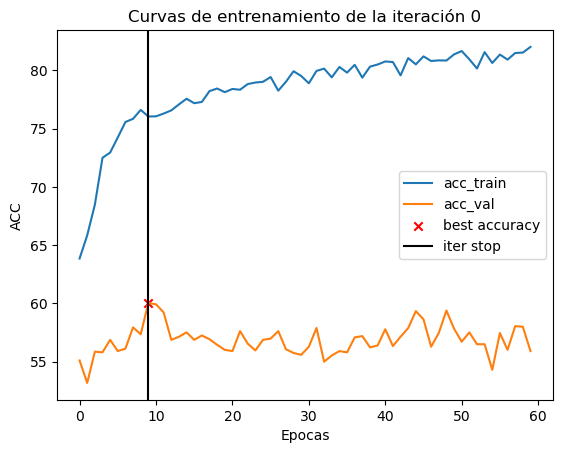

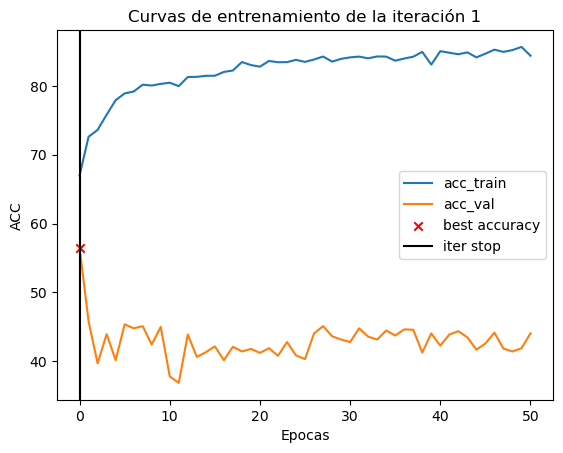

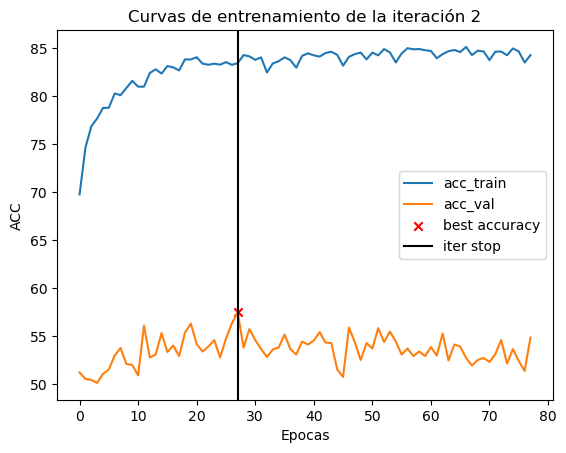

In [137]:
for it in range(N_it): 
    best_acc_val = info_exp[f'it_{it}']['clf_1']['best_acc_val']
    it_stop = info_exp[f'it_{it}']['clf_1']['it_stop']
    
    print(f'it_{it}: ACC_VAL: {100*best_acc_val}')
    
    fig, ax = plt.subplots()
    
    acc_train = info_exp[f'it_{it}']['clf_1']['scores_trains'].copy()
    acc_val = info_exp[f'it_{it}']['clf_1']['scores_val'].copy()
    
    ax.plot(100*np.array(acc_train),label='acc_train')
    ax.plot(100*np.array(acc_val),label='acc_val')
    ax.scatter(float(it_stop),100*best_acc_val,color='r',marker='x',label = 'best accuracy')
    ax.axvline(x=it_stop, ymin=0, ymax=100,label='iter stop',color='k')
    ax.set_xlabel('Epocas')
    ax.set_ylabel('ACC')
    ax.set_title(f'Curvas de entrenamiento de la iteración {it}')
    ax.legend()


In [117]:


    
#Train
it_patience = 0

acc_train = []
acc_val = []

#clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=max_iter,shuffle=True,learning_rate='constant',eta0 = 0.01) #SVM
# clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=max_iter,shuffle=False,learning_rate='constant',eta0 = 0.0001) #SVM


# Classifier
scaler = StandardScaler()
clf = MLPClassifier(hidden_layer_sizes=(10,8,5), activation='relu', solver='adam', alpha=0.0001,
                    learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                    max_iter=max_iter, shuffle=True, random_state=None)
classes = np.unique(Y_train)

best_clf = None
best_acc_val = 0
best_it = 0 

for it in range(max_iter):
    # Train classifier 
    scaler.partial_fit(X_train, Y_train)
    X_train_ = scaler.transform(X_train)
    X_val_ = scaler.transform(X_val)
    
    clf.partial_fit(X_train_,Y_train,classes=classes)
    acc_train.append(clf.score(X_train_,Y_train))
    acc_val.append(clf.score(X_val_,Y_val))
    
    if acc_val[-1] >= best_acc_val:
        best_acc_val = acc_val[-1]
        best_clf = clone(clf)
        best_it = it 
        it_patience = 0
    else: 
        it_patience += 1
    
    if it_patience >= patience:
        print(f'Convergio en la iteración {it-patience}')
        break
    
    
    


    #     if np.abs(acc_val_mean[-1] - acc_val_mean[-2]) <= tol_val 
    
    

Convergio en la iteración 1


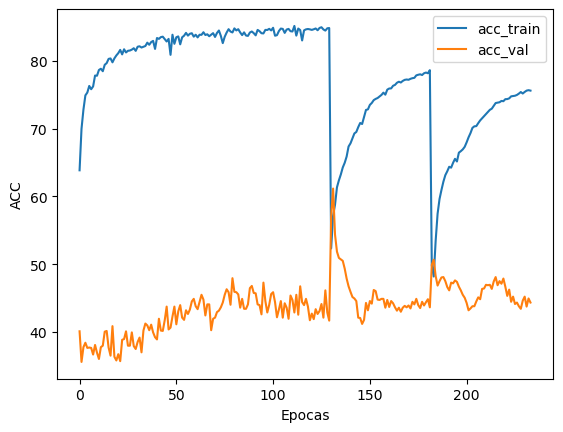

In [118]:
fig, ax = plt.subplots()
ax.plot(100*np.array(acc_train),label='acc_train')
ax.plot(100*np.array(acc_val),label='acc_val')
ax.set_xlabel('Epocas')
ax.set_ylabel('ACC')
ax.legend()


In [119]:
print(reg_idx_test)

[['sub-005', 'sub-004', 'sub-017', 'sub-002']]


# Creamos el conjunto de datos para entrenamiento
X = np.zeros((1,6))
Y = np.zeros(1)
groups = np.array(['aaa'])
for participant in participants_balanced:
    X = np.concatenate((X, dataset_df.loc[participant,'data_csp']),axis=0)
    Y = np.concatenate((Y, dataset_df.loc[participant,'data_gender']),axis=0)
    groups = np.concatenate((groups, dataset_df.loc[participant,'group_participant']),axis=0)

X = X[1:,:]
Y = Y[1:]
groups = groups[1:]